# **1. POWERBALL GAME**
180 days dataset scraped from AZ lottery website. Dataset includes number of winners of different amounts, jackpot estimate, winning numbers, draw dates.


# **Cycle Based Regression: Tickets Sold vs Jackpot**

Saving POWERBALL.xlsx to POWERBALL.xlsx


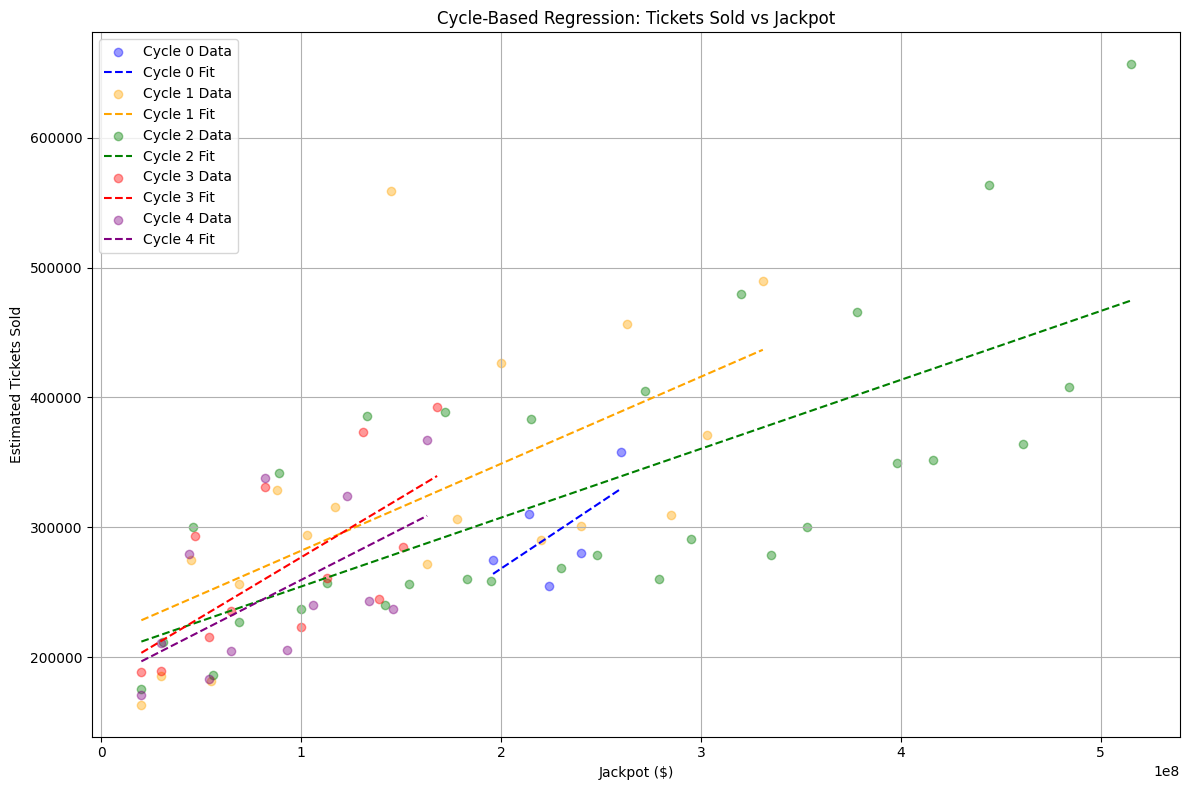


=== Regression Summary Per Cycle ===
   cycle_id   n  linear_r2  poly_r2  log_r2                 equation
0         0   5      0.386    0.640   0.358   y = 63351 + 0.001024*x
1         1  18      0.393    0.432   0.464  y = 215023 + 0.000670*x
2         2  30      0.503    0.527   0.412  y = 201398 + 0.000530*x
3         3  12      0.450    0.451   0.439  y = 184923 + 0.000920*x
4         4  12      0.336    0.338   0.325  y = 181087 + 0.000784*x


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# 📦 PHASE 1: Import Libraries & Upload File
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from google.colab import files

# STEP 1.1: Upload CSV file (drag-and-drop)
uploaded = files.upload()

# Auto-detect filename
import io
file_name = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[file_name]))


# STEP 1.2: Clean & Prepare Data
df.columns = df.columns.str.strip()
df['DRAW DATE'] = pd.to_datetime(df['DRAW DATE'])
df['EST JACKPOT'] = df['EST JACKPOT'].replace({'[$,]': ''}, regex=True).astype(float)
df = df.sort_values('DRAW DATE').reset_index(drop=True)

# === PHASE 2: Segment Into Jackpot Growth Cycles ===
cycle_id = 0
cycles = []
for i in range(len(df)):
    if i > 0 and df.loc[i, 'EST JACKPOT'] < df.loc[i - 1, 'EST JACKPOT']:
        cycle_id += 1
    cycles.append(cycle_id)
df['cycle_id'] = cycles

# STEP 1.3: Estimate Tickets Sold (total_winners × 24.9)
prize_columns = df.select_dtypes(include='number').columns.difference(['EST JACKPOT'])
df['total_winners'] = df[prize_columns].sum(axis=1)
df['est_tickets_sold'] = df['total_winners'] * 24.9

# === PHASE 3: Regression Modeling Per Cycle ===
results = []
plt.figure(figsize=(12, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for cid in df['cycle_id'].unique():
    sub = df[df['cycle_id'] == cid]
    if len(sub) < 3:
        continue

    X = sub[['EST JACKPOT']].values
    y = sub['est_tickets_sold'].values

    # Linear Regression
    lin_model = LinearRegression()
    lin_model.fit(X, y)
    lin_r2 = lin_model.score(X, y)

    # Polynomial Regression (Degree 2)
    poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
    poly_model.fit(X, y)
    poly_r2 = poly_model.score(X, y)

    # Log-Linear Regression
    log_r2 = None
    try:
        X_log = np.log(X)
        log_model = LinearRegression().fit(X_log, y)
        log_r2 = log_model.score(X_log, y)
    except:
        pass

    results.append({
        'cycle_id': cid,
        'n': len(sub),
        'linear_r2': round(lin_r2, 3),
        'poly_r2': round(poly_r2, 3),
        'log_r2': round(log_r2, 3) if log_r2 else None,
        'equation': f"y = {lin_model.intercept_:.0f} + {lin_model.coef_[0]:.6f}*x"
    })

    # Plotting
    y_pred = lin_model.predict(X)
    plt.scatter(X, y, label=f"Cycle {cid} Data", alpha=0.4, color=colors[cid % len(colors)])
    plt.plot(X, y_pred, linestyle='--', color=colors[cid % len(colors)], label=f"Cycle {cid} Fit")

# === PHASE 4: Visualize & Summarize ===
plt.xlabel("Jackpot ($)")
plt.ylabel("Estimated Tickets Sold")
plt.title("Cycle-Based Regression: Tickets Sold vs Jackpot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print regression summary per cycle
summary_df = pd.DataFrame(results)
print("\n=== Regression Summary Per Cycle ===")
print(summary_df)

# === PHASE 5: Export Final File (With Cycles & Ticket Estimates)
df.to_csv("Powerball_Cleaned_With_Cycles.csv", index=False)
files.download("Powerball_Cleaned_With_Cycles.csv")


# **Estimated Jackpot over Time**

<ipython-input-6-8aff0ccdf67f>:24: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


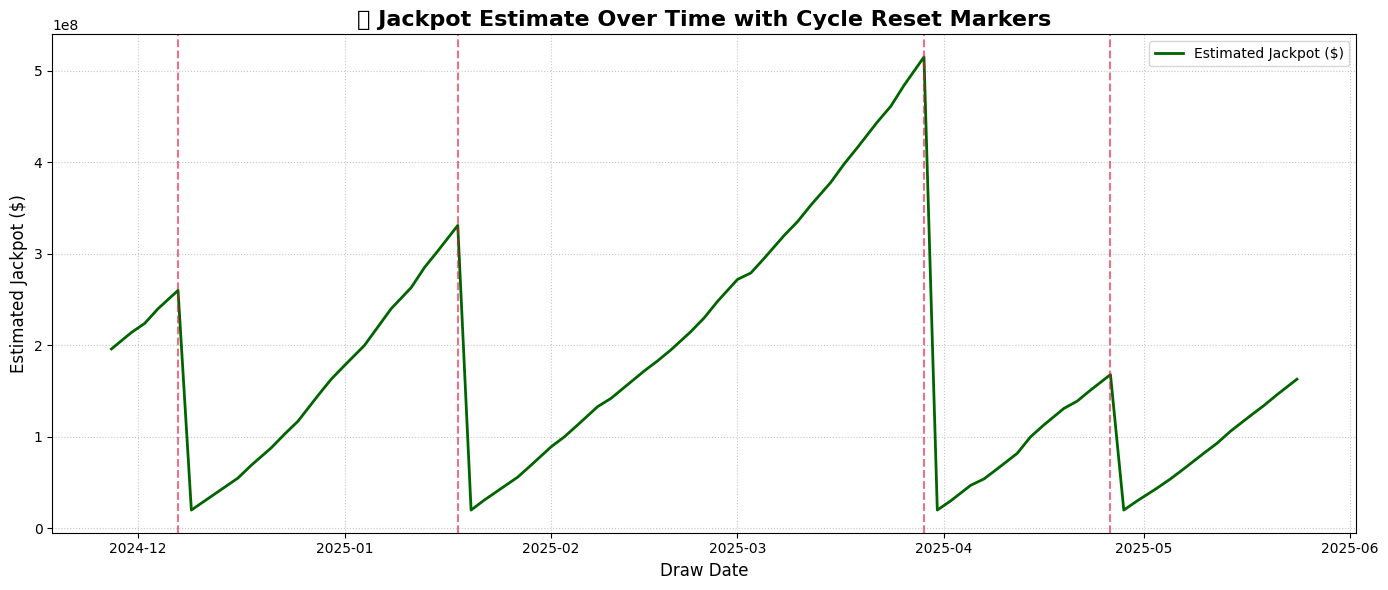

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure your dataframe is already loaded and prepped
# Assumes df contains columns 'DRAW DATE' and 'EST JACKPOT' (already cleaned & sorted)

# Step 1: Identify jackpot peak dates (reset after these)
peak_dates = df.loc[df['EST JACKPOT'] > df['EST JACKPOT'].shift(-1), 'DRAW DATE'].tolist()

# Step 2: Plot jackpot trend with peaks marked
plt.figure(figsize=(14, 6))
plt.plot(df['DRAW DATE'], df['EST JACKPOT'], label='Estimated Jackpot ($)', color='darkgreen', linewidth=2)

# Step 3: Add vertical dashed lines at each peak
for pdx in peak_dates:
    plt.axvline(pdx, color='crimson', linestyle='--', alpha=0.6)

# Aesthetic elements
plt.title("🎯 Jackpot Estimate Over Time with Cycle Reset Markers", fontsize=16, fontweight='bold')
plt.xlabel("Draw Date", fontsize=12)
plt.ylabel("Estimated Jackpot ($)", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# ✅ Convert all column names to string first (fix float issue)
df.columns = df.columns.map(str).str.strip()

# ✅ Dynamically detect all prize columns with "$" in the name
prize_columns = [col for col in df.columns if "$" in str(col)]

# 🔁 Convert prize columns to numeric
df[prize_columns] = df[prize_columns].replace({',': ''}, regex=True).apply(pd.to_numeric, errors='coerce').fillna(0)


<ipython-input-10-7633795d772f>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Prize Tier", bbox_to_anchor=(1.05, 1), loc='upper left')
<ipython-input-10-7633795d772f>:20: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


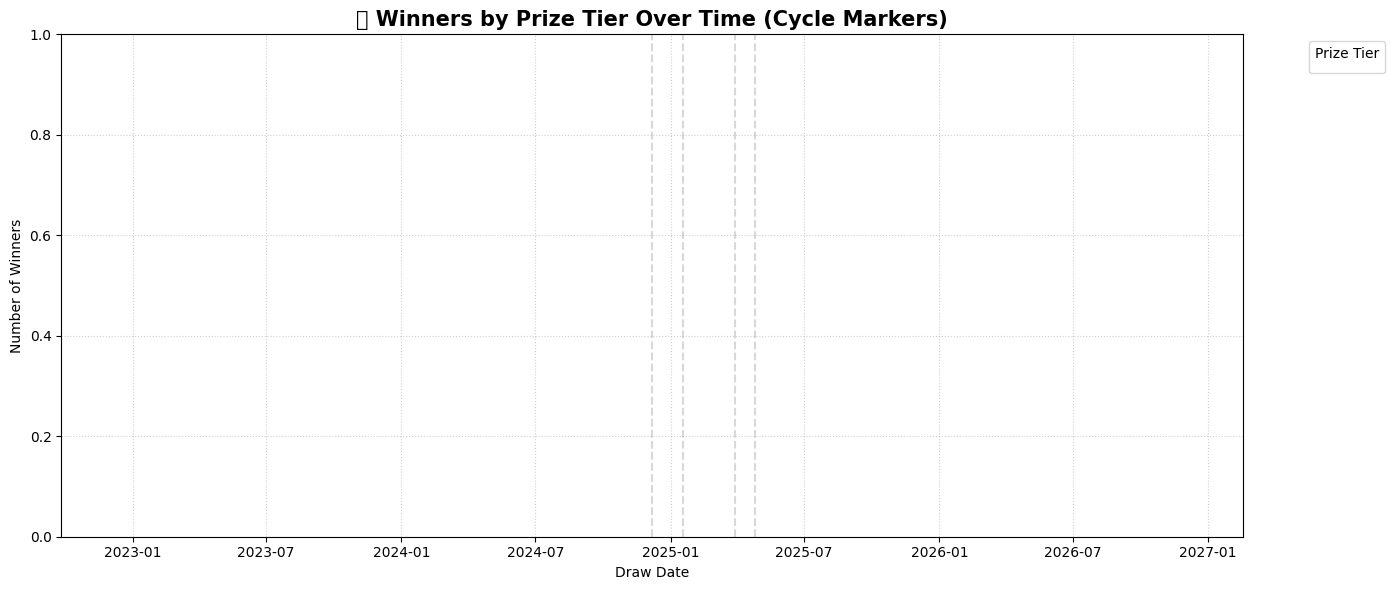

In [10]:
import matplotlib.pyplot as plt

# 📌 Identify jackpot peak dates (resets)
peak_dates = df.loc[df['EST JACKPOT'] > df['EST JACKPOT'].shift(-1), 'DRAW DATE'].tolist()

# 📈 Plot each prize category over time
plt.figure(figsize=(14, 6))

for col in prize_columns:
    plt.plot(df['DRAW DATE'], df[col], label=col, linewidth=1.8)

for pdx in peak_dates:
    plt.axvline(pdx, color='gray', linestyle='--', alpha=0.3)

plt.title("🎯 Winners by Prize Tier Over Time (Cycle Markers)", fontsize=15, fontweight='bold')
plt.xlabel("Draw Date")
plt.ylabel("Number of Winners")
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(title="Prize Tier", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
